In [1]:
%%shell
cp /content/drive/MyDrive/archive.zip .
unzip archive.zip

Archive:  archive.zip
  inflating: emails.csv              


In [31]:
%%shell
pip install unidecode

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.5/235.5 kB 4.6 MB/s eta 0:00:00


In [139]:
import re
import nltk
import numpy as np
import pandas as pd
import plotly.express as px # a partir de df
import plotly.graph_objects as go # personalizacion
import matplotlib.pyplot as plt
from unidecode import unidecode
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from wordcloud import WordCloud
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from imblearn.over_sampling import SMOTE

nltk_pkgs = ["punkt", "stopwords"]
for pkg in nltk_pkgs:
    nltk.download(pkg)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Carga de Datos

In [3]:
df = pd.read_csv("emails.csv")

In [4]:
df

,text,spam
0,Subject: naturally irresistible your corporate...,1
1,Subject: the stock trading gunslinger fanny i...,1
2,Subject: unbelievable new homes made easy im ...,1
3,Subject: 4 color printing special request add...,1
4,"Subject: do not have money , get software cds ...",1
...,...,...
5723,Subject: re : research and development charges...,0
5724,"Subject: re : receipts from visit jim , than...",0
5725,Subject: re : enron case study update wow ! a...,0
5726,"Subject: re : interest david , please , call...",0


# Analisis Exploratorio (EDA - Exploratory Data Analysis)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5728 entries, 0 to 5727
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    5728 non-null   object
 1   spam    5728 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 89.6+ KB


In [6]:
df.columns

Index(['text', 'spam'], dtype='object')

In [15]:
counts = (
    df
    .spam
    .value_counts()
    .reset_index()
    .assign(index=lambda df: df["index"].map({0: "No spam", 1: "Spam"}))
)
counts

,index,spam
0,No spam,4360
1,Spam,1368


In [16]:
fig = (
    px.bar(data_frame=counts, x="index", y="spam")
    .update_layout(xaxis_title="Label", yaxis_title="Counts", title="Counts per label")
)
fig.show()

In [18]:
all_text = " ".join(df.text.to_list())

In [22]:
all_text[:600]

'Subject: naturally irresistible your corporate identity  lt is really hard to recollect a company : the  market is full of suqgestions and the information isoverwhelminq ; but a good  catchy logo , stylish statlonery and outstanding website  will make the task much easier .  we do not promise that havinq ordered a iogo your  company will automaticaily become a world ieader : it isguite ciear that  without good products , effective business organization and practicable aim it  will be hotat nowadays market ; but we do promise that your marketing efforts  will become much more effective . here i'

In [24]:
tokens = word_tokenize(all_text)

In [26]:
counts = Counter(tokens)

(-0.5, 399.5, 199.5, -0.5)

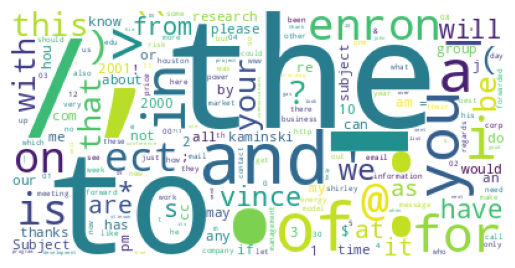

In [27]:
wc = WordCloud(background_color="white").generate_from_frequencies(counts)
fig, ax = plt.subplots()
ax.imshow(wc)
ax.axis("off")

In [28]:
all_text = " ".join(df.query("spam == 0").text.to_list())
tokens = word_tokenize(all_text)
counts_nospam = Counter(tokens)

all_text = " ".join(df.query("spam == 1").text.to_list())
tokens = word_tokenize(all_text)
counts_spam = Counter(tokens)

[Text(0.5, 1.0, 'spam')]

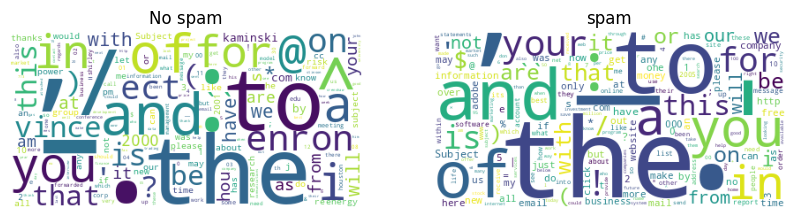

In [30]:
fig, axes = plt.subplots(1, 2, figsize=(10, 6))
ax = axes[0]
wc = WordCloud(background_color="white").generate_from_frequencies(counts_nospam)
ax.imshow(wc)
ax.axis("off")
ax.set(title="No spam")

ax = axes[1]
wc = WordCloud(background_color="white").generate_from_frequencies(counts_spam)
ax.imshow(wc)
ax.axis("off")
ax.set(title="spam")

# Limpieza

In [47]:
sw = stopwords.words("english")
sp_pat = re.compile(r"[^a-z ]")
spa_pat = re.compile(r"\s")
sub_pat = re.compile(r"^subject ")
def preprocess(text: str) -> str:
    lower_text = text.lower()
    norm_text = unidecode(lower_text)
    tokens = word_tokenize(norm_text)
    filtered_tokens = filter(
        lambda token: (
            (token not in sw) and
            (len(token) > 2) and
            (len(token) < 15)
            ),
        tokens
    )
    filtered_text = " ".join(filtered_tokens)
    sp_text = re.sub(sp_pat, " ", filtered_text)
    spa_text = re.sub(spa_pat, " ", sp_text)
    sub_text = re.sub(sub_pat, "", spa_text)
    return sub_text.strip()

In [48]:
y = (x := 2)

In [49]:
x, y

(2, 2)

In [50]:
df_preprocess = df.assign(text=(prep := df.text.apply(preprocess)))

In [51]:
prep

0       naturally irresistible corporate identity real...
1       stock trading gunslinger fanny merrill muzo co...
2       unbelievable new homes made easy wanting show ...
3       color printing special request additional info...
4       money get software cds software compatibility ...
                              ...                        
5723    research development charges gpg forwarded shi...
5724    receipts visit jim thanks invitation visit lsu...
5725    enron case study update wow day super thank mu...
5726    interest david please call shirley crenshaw as...
5727    news aurora update aurora version fastest mode...
Name: text, Length: 5728, dtype: object

In [52]:
df_preprocess

,text,spam
0,naturally irresistible corporate identity real...,1
1,stock trading gunslinger fanny merrill muzo co...,1
2,unbelievable new homes made easy wanting show ...,1
3,color printing special request additional info...,1
4,money get software cds software compatibility ...,1
...,...,...
5723,research development charges gpg forwarded shi...,0
5724,receipts visit jim thanks invitation visit lsu...,0
5725,enron case study update wow day super thank mu...,0
5726,interest david please call shirley crenshaw as...,0


# Extraccion de Caracteristicas

In [118]:
vect = CountVectorizer(min_df=3, max_df=0.8, max_features=2000).fit(df_preprocess.text)
#vect = TfidfVectorizer(min_df=3, max_df=0.8, max_features=2000).fit(df_preprocess.text)

In [119]:
features = vect.transform(df_preprocess.text).toarray()

In [120]:
features.shape

(5728, 2000)

In [121]:
label = df.spam.to_numpy()
label.shape

(5728,)

In [140]:
(
    features_train,
    features_test,
    labels_train,
    labels_test
    ) = train_test_split(
        features, label,
        test_size=0.3, stratify=label,
        random_state=0
        )

In [141]:
sampler = SMOTE()
features_train, labels_train = sampler.fit_resample(
    features_train, labels_train
)

In [142]:
features_train.shape

(6104, 2000)

In [143]:
features_test.shape

(1719, 2000)

In [144]:
scratch_df = (
    pd.DataFrame(
        dict(
            partition=[
                *("train" for i in range(features_train.shape[0])),
                *("test" for i in range(features_test.shape[0]))
                ],

            label=np.concatenate([labels_train, labels_test])
            )
    )
    .assign(dummy=1)
    .groupby(by=["partition", "label"])
    .agg({"dummy": "sum"})
    .reset_index()
)
scratch_df

,partition,label,dummy
0,test,0,1308
1,test,1,411
2,train,0,3052
3,train,1,3052


In [145]:
fig = px.bar(data_frame=scratch_df, x=["label"], y="dummy", color="partition")
fig.show()

In [146]:
(
    scratch_df
    .query("partition == 'train'")
    .assign(prop=lambda df: df.dummy / df.dummy.sum())
    .filter(["label", "prop"])
)

,label,prop
2,0,0.5
3,1,0.5


In [147]:
(
    scratch_df
    .query("partition == 'test'")
    .assign(prop=lambda df: df.dummy / df.dummy.sum())
    .filter(["label", "prop"])
)

,label,prop
0,0,0.760908
1,1,0.239092


# Modelamiento

In [148]:
model = LogisticRegression().fit(features_train, labels_train)

# Evalucion

In [149]:
model.score(features_test, labels_test)

0.9802210587550901

In [150]:
y_pred = model.predict(features_test)
cm = confusion_matrix(labels_test, y_pred)
scratch_df = pd.DataFrame(
    data=cm, columns=(cols := ["no spam", "spam"]),
    index=cols
    )

In [151]:
fig = (
    px.imshow(scratch_df, color_continuous_scale="gray")
    .update_layout(xaxis_title="Predicted", yaxis_title="True")
)
fig.show()